In [1]:
cd /home

/home


In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np
import toml 
import os

from src.models import get_ASTROMER_II
from src.data import load_data
from matplotlib import gridspec

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
WEIGTHS = './presentation/experiments/astromer_2/results/nsp_normal/2023-07-24_22-43-38/pretraining/'
with open(os.path.join(WEIGTHS, 'config.toml'), 'r') as f:
    model_config = toml.load(f)

In [8]:
astromer = get_ASTROMER_II(num_layers=model_config['layers'],
                           num_heads=model_config['nh'],
                           head_dim=model_config['hdim'],
                           mixer_size=model_config['mixer'],
                           dropout=model_config['dropout'],
                           pe_base=1000,
                           pe_dim=model_config['pe_dim'],
                           pe_c=1,
                           window_size=model_config['ws'],
                           encoder_mode=model_config['encoder_mode'],
                           average_layers=model_config['avg_layers'],
                           off_nsp=model_config['off_nsp'])
    
astromer.load_weights(os.path.join(WEIGTHS, 'weights')).expect_partial()

In [10]:
batches = load_data(dataset=os.path.join('./data/records/macho_clean/', 'val'), 
                    batch_size=32, 
                    probed=1,#model_config['probed'],  
                    window_size=model_config['ws'], 
                    nsp_prob=0,#model_config['nsp_prob'], 
                    repeat=1, 
                    sampling=False,
                    test_mode=True,
                    off_nsp=model_config['off_nsp'])

[INFO] TESTING MODE


In [43]:
for x, y in batches.take(1):
    try:
        y_cls, y_pred = astromer(x)
        y_mask = y['probed_mask']
        y_true_cls = y['nsp_label']
        y_true = y['magnitudes']
        times = x['times'][:, 1:, :]  
        x_original = x['original']
    except:
        y_pred = astromer(x)
        y_cls = np.array([[0, 1]]*len(y_pred))[..., None]
        print(y_cls.shape)
        y_mask = y['probed_mask']
        y_true_cls = np.array([[1]]*len(y_pred))
        print(y_true_cls.shape)
        y_true = y['magnitudes']
        times = x['times']  
        x_original = x['original']
        
print(y_mask.shape)

(32, 2, 1)
(32, 1)
(32, 200, 1)


Text(0.96, 0.5, 'Predicted Magnitude')

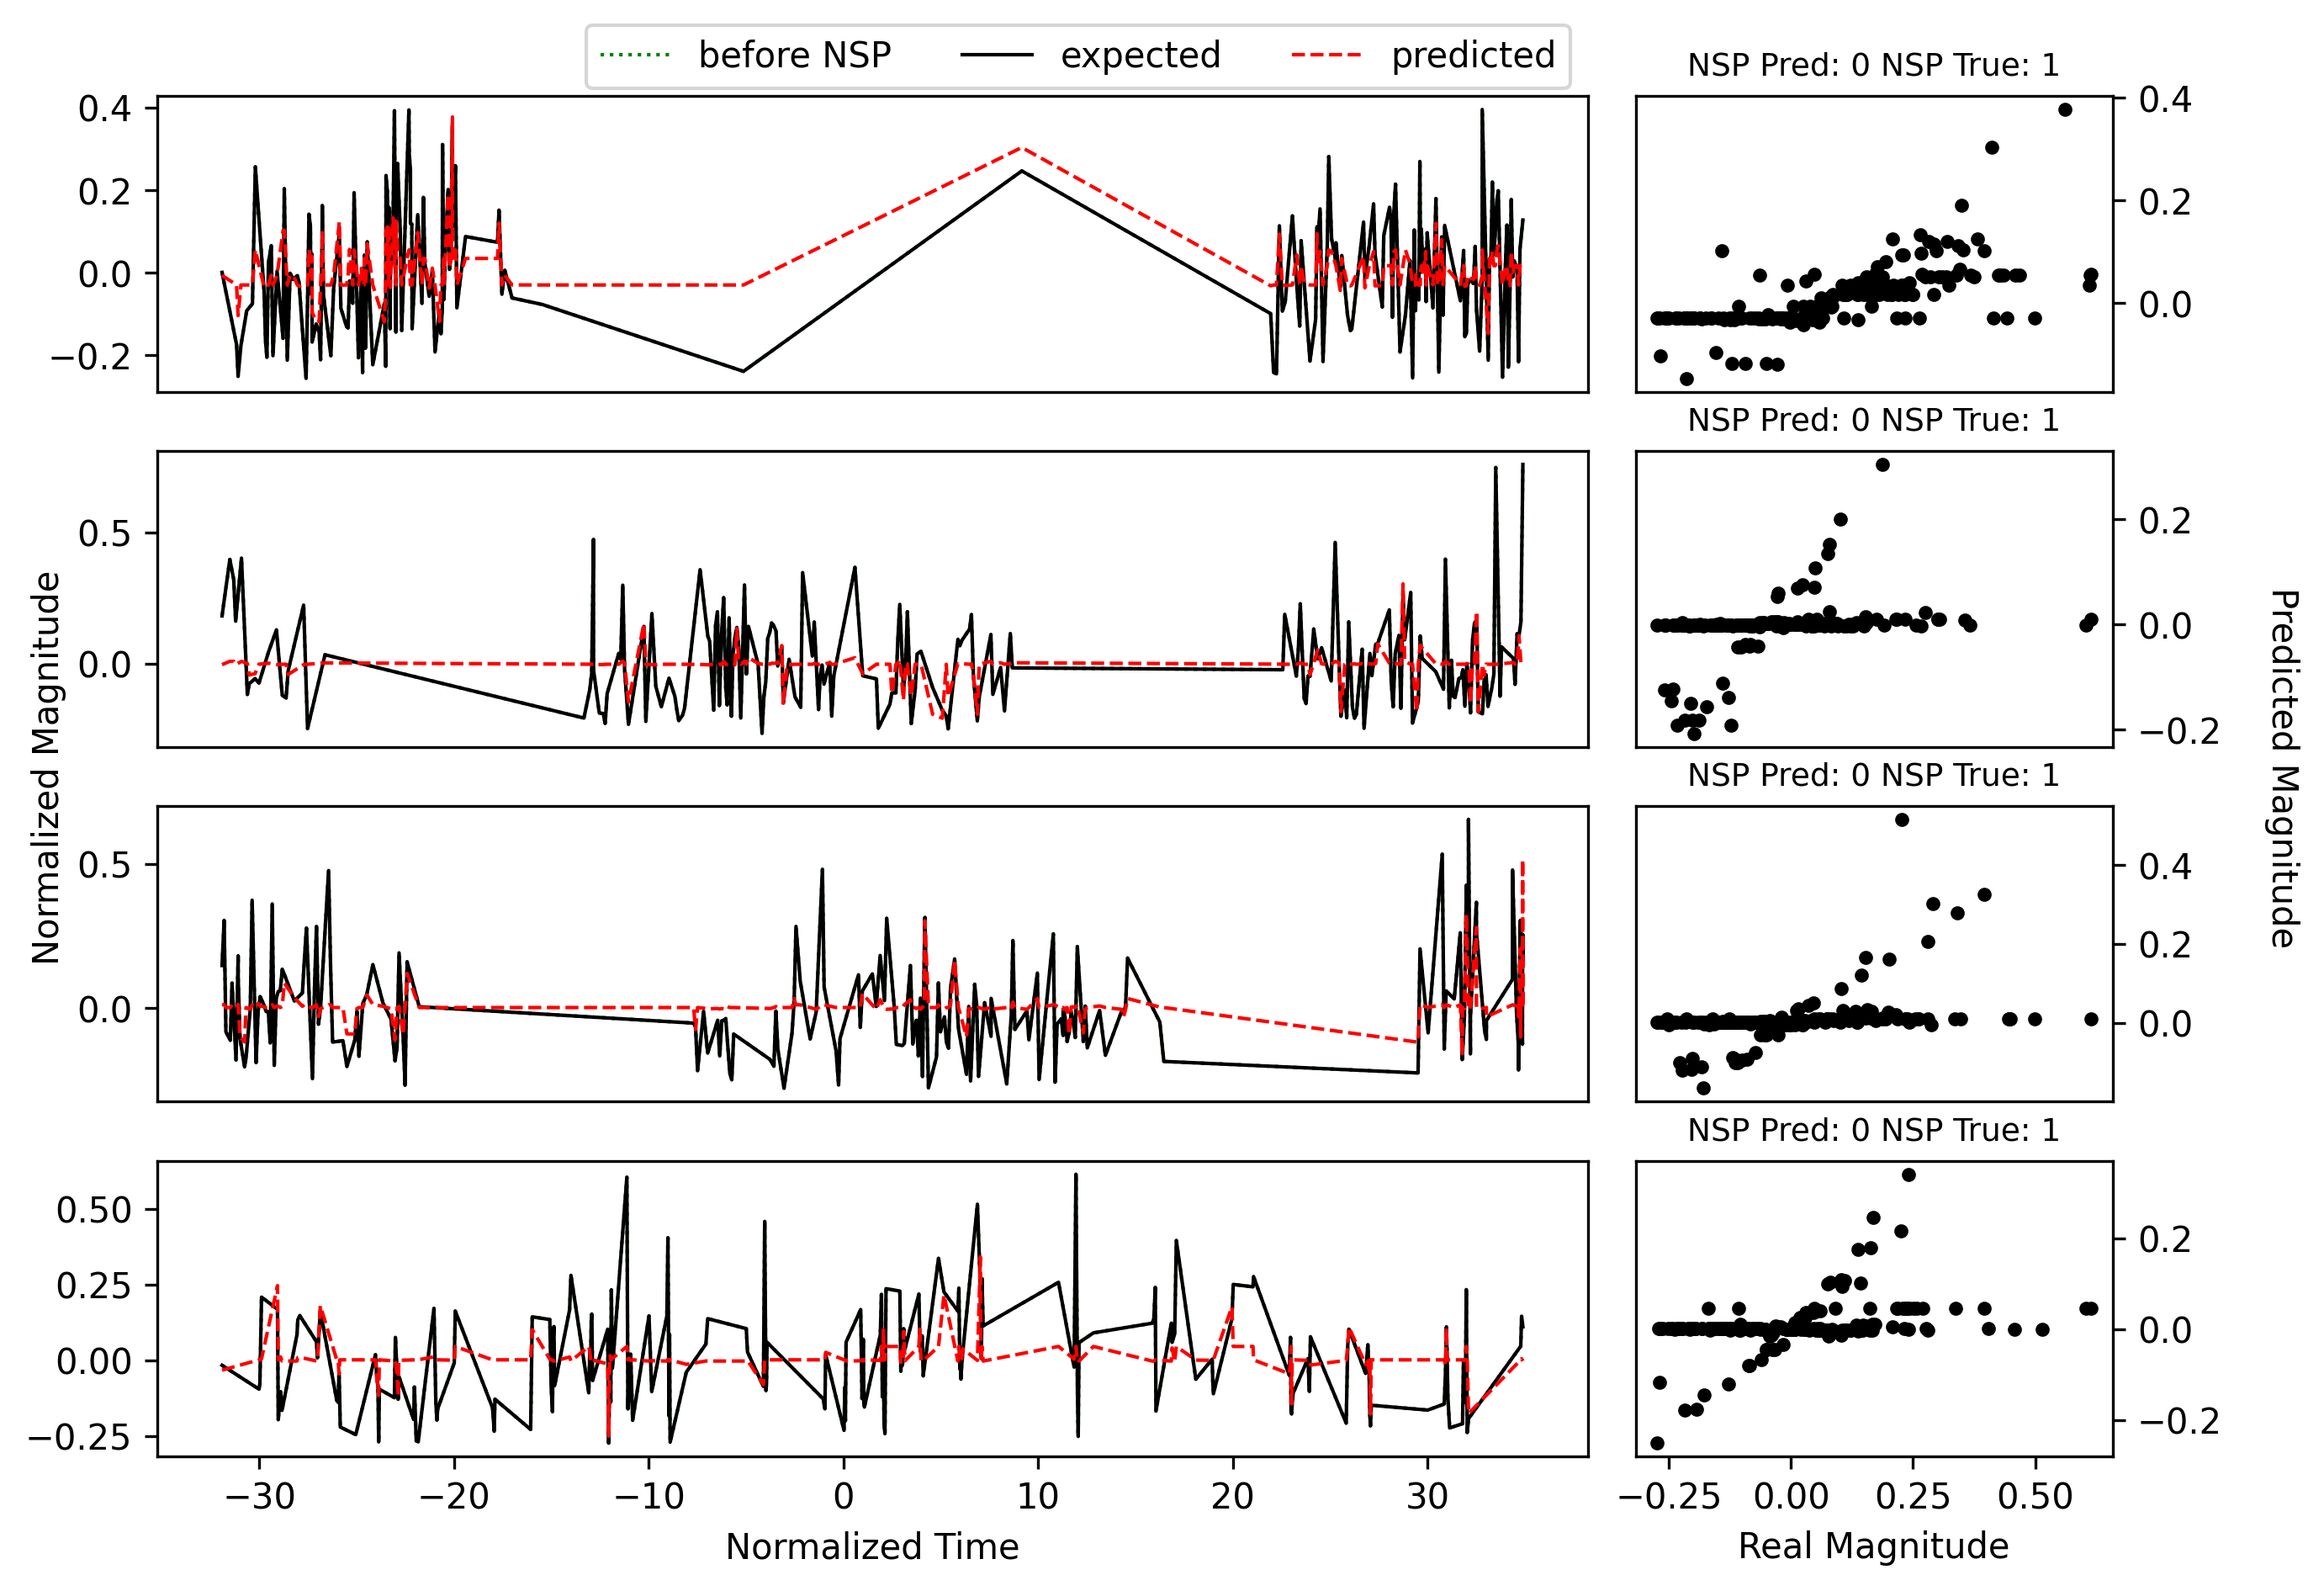

In [44]:
N = 4
                  
fig = plt.figure(figsize=(10,7), dpi=300)
gs = gridspec.GridSpec(N, 2, width_ratios=[3, 1]) 
plt.subplots_adjust(hspace=0.2, wspace=0.05)
for i, x, y, m, t, nsppred, nsptrue, xo in zip(range(N), y_true, y_pred, 
                                               y_mask, times, y_cls, 
                                               y_true_cls, x_original):
    ax0 = plt.subplot(gs[i, 0])
    ax1 = plt.subplot(gs[i, 1])
            
    probed_pred  = tf.boolean_mask(y, m)
    probed_true  = tf.boolean_mask(x, m)
    probed_time  = tf.boolean_mask(t, m)
    original_seq = tf.boolean_mask(xo[:, 1, None], m)
    
    ax0.plot(probed_time, original_seq, marker='', linewidth=1, linestyle=':', color='g', label='before NSP')
    ax0.plot(probed_time, probed_true, marker='', linewidth=1, linestyle='-', color='k', label='expected')
    ax0.plot(probed_time, probed_pred, marker='', linewidth=1, linestyle='--', color='r', label='predicted')

    ax1.plot(probed_true, probed_pred, '.', color='k')
    if i< N-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax1.set_xticks([])
        
    ax1.yaxis.tick_right() 
    nsp_predicted = tf.argmax(nsppred, 1)[0]
    nsp_real = int(nsptrue[0])

    ax1.set_title('NSP Pred: {} NSP True: {}'.format(nsp_predicted, nsp_real), fontsize=9)
    
    if i ==0:
        ax0.legend(ncol=3,bbox_to_anchor=(1, 1.3))
        
ax0.set_xlabel('Normalized Time')

ax1.set_xlabel('Real Magnitude')
fig.text(0.075, 0.5, 'Normalized Magnitude', va='center', rotation='vertical')
fig.text(0.96, 0.5, 'Predicted Magnitude', va='center', rotation=-90)